Library installation

In [ ]:
%%bash

sudo apt install curl

In [ ]:
!pip install dipy

Library import

In [1]:
import matplotlib.pylab as plt
import os
import numpy as np
from scipy.ndimage import binary_dilation

In [2]:
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti_data, load_nifti, save_nifti
from dipy.direction import peaks
from dipy.reconst import shm
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.tracking.streamline import Streamlines

/home/mzelasko/miniconda3/envs/ML4Neuro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk

In [155]:
def take_import_text(number = 10159):
    f = open("./Data/ds000030-1.0.0.sh", "r")
    lines_array = f.readlines()
    lines_import_text = ""
    nii_gz_filenames = []
    for line in lines_array:
        if f"sub-{number}" in line[-60:]: 
            lines_import_text += line
            if "nii.gz" in line[-10:]:
                words = line.split(" ")
                nii_gz_filenames.append(words[-1][:-1])
    return lines_import_text, nii_gz_filenames

In [156]:
def create_bash_script(number = 10159, do_import = True):
    # removing previous script
    try:
        os.system('rm ./Data/import_process_script.sh')
    except:
        print("No script file to remove!")

    # cut part of import script to download one directory
    bin_bash = f"#!/bin/bash\n"
    import_data, nii_gz_filenames = take_import_text(number)
    if not do_import: import_data = ""
    
    # extracting mask file from nii.gz files
    convert_data_fsl = "export FSLOUTPUTTYPE=NIFTI_GZ\nexport PATH=\"/usr/local/fsl/bin$PATH\"\nexport FSLDIR=\"/usr/local/fsl\""
    for filename in nii_gz_filenames:
        convert_data_fsl += f"bet ./{filename} ./{filename[:-7]}mask{filename[-7:]}\n" #f"dir=\"./Data/sub-{number}\"\nnifti_dir=\"processed-data/sub-{number}/\"\nmkdir processed-data\nmkdir $nifti_dir\ndcm2niix -o $nifti_dir $dir"
    
    # create script and write it to file
    script_text = bin_bash + import_data + convert_data_fsl
    print(script_text)
    f = open("./Data/import_process_script.sh", "w")
    f.write(script_text)

In [167]:
print("export FSLOUTPUTTYPE=NIFTI_GZ\nexport PATH=\"/usr/local/fsl/bin$PATH\"\nexport FSLDIR=\"/usr/local/fsl\"")

export FSLOUTPUTTYPE=NIFTI_GZ
export PATH="/usr/local/fsl/bin$PATH"
export FSLDIR="/usr/local/fsl"


In [157]:
create_bash_script()

#!/bin/bash
curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds000030/sub-10159/anat/sub-10159_T1w.json?versionId=mWHa_s6teNNQu1_983mKa1pbABdigX61 -o sub-10159/anat/sub-10159_T1w.json
curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds000030/sub-10159/anat/sub-10159_T1w.nii.gz?versionId=xZH9NrMLEiRpxXIS7D6gg7OEz3g85RlE -o sub-10159/anat/sub-10159_T1w.nii.gz
curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds000030/sub-10159/beh/sub-10159_task-stopsignaltraining_beh.json?versionId=T7MotERk31GEAr1ufmMERPQ8vUgh9mq2 -o sub-10159/beh/sub-10159_task-stopsignaltraining_beh.json
curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds000030/sub-10159/beh/sub-10159_task-stopsignaltraining_events.tsv?versionId=Iu9VHoM8aX.bFeKFSIE1zHceoGK9AwQR -o sub-10159/beh/sub-10159_task-stopsignaltraining_events.tsv
curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds000030/sub-70086/dwi/sub-70086_dwi.bval?versionId=eZJYZu2Wf9Vn26caaX68LZdNeJ_VVYW5 -o sub-10159/dwi/sub-

In [158]:
def run_script(number = 10159, do_import = True):
    # create script importing and converting single directory
    create_bash_script(number=number, do_import=do_import)

    # run script in bash
    os.system('bash ./Data/import_process_script.sh')

In [159]:
run_script()

#!/bin/bash
curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds000030/sub-10159/anat/sub-10159_T1w.json?versionId=mWHa_s6teNNQu1_983mKa1pbABdigX61 -o sub-10159/anat/sub-10159_T1w.json
curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds000030/sub-10159/anat/sub-10159_T1w.nii.gz?versionId=xZH9NrMLEiRpxXIS7D6gg7OEz3g85RlE -o sub-10159/anat/sub-10159_T1w.nii.gz
curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds000030/sub-10159/beh/sub-10159_task-stopsignaltraining_beh.json?versionId=T7MotERk31GEAr1ufmMERPQ8vUgh9mq2 -o sub-10159/beh/sub-10159_task-stopsignaltraining_beh.json
curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds000030/sub-10159/beh/sub-10159_task-stopsignaltraining_events.tsv?versionId=Iu9VHoM8aX.bFeKFSIE1zHceoGK9AwQR -o sub-10159/beh/sub-10159_task-stopsignaltraining_events.tsv
curl --create-dirs https://s3.amazonaws.com/openneuro.org/ds000030/sub-70086/dwi/sub-70086_dwi.bval?versionId=eZJYZu2Wf9Vn26caaX68LZdNeJ_VVYW5 -o sub-10159/dwi/sub-

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1180  100  1180    0     0    916      0  0:00:01  0:00:01 --:--:--   916
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.0M  100 11.0M    0     0   973k      0  0:00:11  0:00:11 --:--:-- 1161k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   425  100   425    0     0    365      0  0:00:01  0:00:01 --:--:--   365
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23865  100 23865    0     0  18100      0  0:00:01  0:00:01 --:--:-- 18106
  % Total    % Received % Xferd  Average Speed   Tim

In [149]:
def process_to_streamlines(filename = None, number = 10159, do_draw = False):
    # load data
    if filename == None:
        data, affine, load_img = load_nifti(f"./sub-{number}/dwi/sub-{number}_dwi.nii.gz", return_img=True) #f"./sub-{number}/anat/sub-10159_T1w.nii.gz"
        bvals, bvecs = read_bvals_bvecs(f"./sub-{number}/dwi/sub-{number}_dwi.bval", f"./sub-{number}/dwi/sub-{number}_dwi.bvec")
        gtab = gradient_table(bvals, bvecs)
        labels = load_nifti_data(f"./sub-{number}/dwi/sub-{number}_dwimask.nii.gz")
    else:
        data, affine, load_img = load_nifti(filename, return_img=True) #f"./sub-{number}/anat/sub-10159_T1w.nii.gz"
        bvals, bvecs = read_bvals_bvecs(f"./sub-{number}/dwi/sub-{number}_dwi.bval", f"./sub-{number}/dwi/sub-{number}_dwi.bvec")
        gtab = gradient_table(bvals, bvecs)
        labels = load_nifti_data(filename[:-7] + "mask.nii.gz")

    # choosing part of the brain
    # white_matter = binary_dilation((labels == 1) | (labels == 2)) 
    # it probably doesn't work this way, white_matter mask may look different in this files
    white_matter = binary_dilation((labels == 1) | (labels == 2)) 
    csamodel = shm.CsaOdfModel(gtab, 6)
    print(white_matter.shape, data.shape)
    csapeaks = peaks.peaks_from_model(model=csamodel,
                                    data=data,
                                    sphere=peaks.default_sphere,
                                    relative_peak_threshold=.8,
                                    min_separation_angle=45)

    affine = np.eye(4)
    seeds = utils.seeds_from_mask(white_matter, affine, density=1)
    stopping_criterion = BinaryStoppingCriterion(white_matter)

    # choosing tracks model
    streamline_generator = LocalTracking(csapeaks, stopping_criterion, seeds,
                                        affine=affine, step_size=0.5) # we can change stopping criterion here
    streamlines = Streamlines(streamline_generator)

    # choosing proper brain slice (verify if it is necessary)
    cc_slice = labels == 2
    cc_streamlines = utils.target(streamlines, affine, cc_slice)
    cc_streamlines = Streamlines(cc_streamlines)

    # save streamlines
    sft = StatefulTractogram(cc_streamlines, load_img, Space.VOX)
    save_trk(sft, "cc_streamlines.trk")

    # create connectivity matrix
    print(cc_streamlines)
    M, _ = utils.connectivity_matrix(cc_streamlines, affine,
                                        labels.astype(np.uint8),
                                        return_mapping=True,
                                        mapping_as_streamlines=True)
    M[:3, :] = 0
    M[:, :3] = 0

    # plot cennectivity matrix
    if do_draw:
        plt.imshow(np.log1p(M), interpolation='nearest')
        plt.savefig(f"connectivity-{number}.png")

    return M   

(96, 96, 50) (96, 96, 50, 65)
ArraySequence([array([[27.54849369, 21.85926579, 28.83771649],
       [28.        , 22.        , 29.        ],
       [28.45150631, 22.14073421, 29.16228351],
       [28.91040889, 22.32396187, 29.23867749],
       [29.38923496, 22.46186586, 29.28000647]]), array([[28.35534141, 56.27761619, 35.78398672],
       [28.        , 56.        , 36.        ],
       [27.64465859, 55.72238381, 36.21601328]]), array([[27.98215978, 55.55688606, 35.7690633 ],
       [28.        , 56.        , 36.        ],
       [28.01784022, 56.44311394, 36.2309367 ],
       [28.05641501, 56.92347823, 36.36421137],
       [28.09603662, 57.41215641, 36.46231218]]), array([[28.88375342, 55.58081163, 35.94878565],
       [28.41714281, 55.74907831, 35.8858502 ],
       [28.        , 56.        , 36.        ],
       [27.58285719, 56.25092169, 36.1141498 ]]), array([[27.72264939, 56.10861609, 35.59840421],
       [28.        , 56.        , 36.        ],
       [28.27735061, 55.89138391, 3

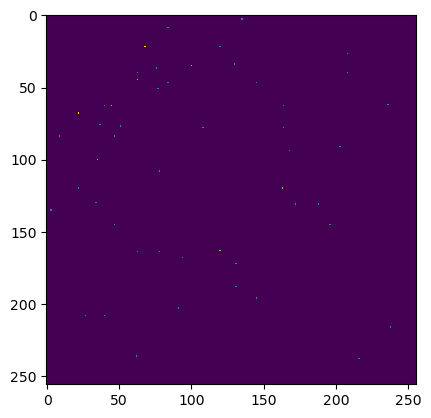

In [150]:
print(process_to_streamlines(number = 10159, do_draw = True))

In [160]:
def write_conectivity_matrix_to_file(M, number = 10159):
    # save connectivity matrix as a .txt file
    # filename consists a directory number
    f = open(f"./cc_matrices/connectivity-matrix-{number}.txt", "w")
    for row in M:
        for cell in row:
            f.write(str(cell) + ",")
        f.write("\n")

In [161]:
def remove_sub_directory(number):
    # remove downloaded directory with data
    try:
        os.system(f"rm -r sub-{number}")
    except:
        print("No directory to remove!")

In [162]:
def preprocess_single_record(number = 10159, do_draw = False):
    # main function for data preprocessing
    # run_script(number)
    M = process_to_streamlines(number = number, do_draw = do_draw)
    write_conectivity_matrix_to_file(M, number=number)
    remove_sub_directory(number)

In [163]:
preprocess_single_record(number = 10159, do_draw = False)

(96, 96, 50) (96, 96, 50, 65)
ArraySequence([array([[27.54849369, 21.85926579, 28.83771649],
       [28.        , 22.        , 29.        ],
       [28.45150631, 22.14073421, 29.16228351],
       [28.91040889, 22.32396187, 29.23867749],
       [29.38923496, 22.46186586, 29.28000647]]), array([[28.35534141, 56.27761619, 35.78398672],
       [28.        , 56.        , 36.        ],
       [27.64465859, 55.72238381, 36.21601328]]), array([[27.98215978, 55.55688606, 35.7690633 ],
       [28.        , 56.        , 36.        ],
       [28.01784022, 56.44311394, 36.2309367 ],
       [28.05641501, 56.92347823, 36.36421137],
       [28.09603662, 57.41215641, 36.46231218]]), array([[28.88375342, 55.58081163, 35.94878565],
       [28.41714281, 55.74907831, 35.8858502 ],
       [28.        , 56.        , 36.        ],
       [27.58285719, 56.25092169, 36.1141498 ]]), array([[27.72264939, 56.10861609, 35.59840421],
       [28.        , 56.        , 36.        ],
       [28.27735061, 55.89138391, 3

In [10]:
def take_import_text(index = 0):
    index = index % 4
    f = open("./Data/ds000030-1.0.0.sh", "r")
    lines_array = f.readlines()
    directory_numbers_set = set()
    for line in lines_array:
        if f"_dwi.nii.gz" in line[-60:]: 
            directory_numbers_set.add(int(line[-17:-12]))
    directory_numbers_list = list(directory_numbers_set)
    directory_numbers_list = sorted(directory_numbers_list)
    n = len(directory_numbers_list)
    return directory_numbers_list[index * n // 4:(index + 1) * n // 4]

In [11]:
print(take_import_text(0), len(take_import_text(0)))
print(take_import_text(1), len(take_import_text(1)))
print(take_import_text(2), len(take_import_text(2)))
print(take_import_text(3), len(take_import_text(3)))

[10159, 10171, 10189, 10193, 10206, 10217, 10225, 10227, 10228, 10235, 10249, 10269, 10271, 10273, 10274, 10280, 10290, 10292, 10304, 10316, 10321, 10325, 10329, 10339, 10340, 10345, 10347, 10356, 10361, 10365, 10376, 10377, 10388, 10429, 10438, 10440, 10448, 10455, 10460, 10471, 10478, 10487, 10492, 10506, 10517, 10523, 10524, 10525, 10527, 10530, 10557, 10565, 10570, 10575, 10624, 10629, 10631, 10638, 10674, 10678, 10680, 10686, 10692, 10696, 10697] 65
[10704, 10707, 10708, 10719, 10724, 10746, 10762, 10779, 10785, 10788, 10844, 10855, 10871, 10877, 10882, 10891, 10893, 10912, 10934, 10940, 10948, 10949, 10958, 10963, 10968, 10975, 10977, 10987, 10998, 11019, 11030, 11044, 11050, 11052, 11059, 11061, 11062, 11066, 11067, 11068, 11077, 11082, 11088, 11090, 11097, 11098, 11104, 11105, 11106, 11108, 11112, 11122, 11128, 11131, 11142, 11143, 11149, 11156, 50004, 50005, 50006, 50007, 50008, 50010, 50013, 50014] 66
[50015, 50016, 50020, 50021, 50022, 50023, 50025, 50027, 50029, 50032, 5003

In [ ]:
def proprocess_record_batch(index = 0):
    index_list = take_import_text(index)
    for index in index_list:
        preprocess_single_record(number = index, do_draw = False)

In [ ]:
# put your index
proprocess_record_batch(index = 0) 